**Authors :** SUKERATHA Alexandre, CHAOUI Anas, LLORET Lisa, LEVENCHAUD Axalia

# Projet SD-201 : Predicting the musical genre of a song

#### Music is both a form of individual expression and a source of collective or spiritual gathering. Its various meanings are reflected in different musical genres. Each genre has its own characteristics of timbre, frequency and tempo. However, genres are not categorical and are interrelated. The multiplicity of influences in the context of artistic creation sometimes makes it difficult to attribute a single genre to a music. In this context: is classification achievable? 

#### In this project, we will consider two databases extracted from Spotify using the same API. The first one is composed of tracks of relatively similar genres `plyalist_genre` and will be the occasion to test multiple classification approaches. The second DataSet is made up of tracks from more distinct genres. It will be used to create clusters and identify musical sub-genres.

#### **Problematic :** Can we achieve a good classification of music genres using Spotify Data?
***

#### _**Warning :** The accuracy score shown in this project may vary slightly when this NoteBook is recalculated. In fact, when running this NoteBook, you will create new training and test subsets where the data is randomly shuffled. As a result, the models you train will be different from those we have calculated on our personal machines._

## Table of Contents
* **[1. Quick overview of the DataSet ; Data Visualization & Pre-Processing](#chapter1)**
    * [1.1 Raw Data](#section_1_1)    
        * _[1.1.1 Raw Data - Features Overview](#sub_section_1_1_1)_
    * [1.2 Checking the DataSet for duplicates or NaN values](#section_1_2)
    * [1.3 Tailoring the data to our needs](#section_1_3)
    * [1.4 One Hot Encoder](#section_1_4)
    * [1.5 Data Visualization](#section_1_5)
        * _[1.5.1 Playlist genre distribution](#sub_section_1_5_1)_
        * _[1.5.2 Features density for each playlist genre](#sub_section_1_5_2)_
        * _[1.5.3 Correlation between features](#sub_section_1_5_3)_
    * [1.6 Normalizing the Data](#section_1_6)
    * [1.7 Final DataFrame](#section_1_7)
    $\\$
* **[2. Baseline classification approach - Naive Bayes Classifier](#chapter2)**
    * [2.1 Train and Test DataSets](#section_2_1)
    * [2.2 Bayes naive Gaussian](#section_2_2) 
    $\\$
* **[3. First classification approach - Knn method](#chapter3)**
    * [3.1 Knn-model (n_neighbors = 3)](#section_3_1) 
    * [3.2 Tuning the HyperParameters of our model](#section_3_2)
    $\\$
* **[4. Second classification approach - Decision Trees](#chapter4)**
    * [4.1 Decision Tree](#section_4_1)
    * [4.2 Random Forest](#section_4_2) 
    * [4.3 Identifying key features](#section_4_3)
    * [4.4 Tuning the HyperParameters : Random Cross Validation](#section_4_4)
    $\\$
* **[5. Clustering method - K-Means](#chapter5)**
    * [5.1 Clustering on the original Data Set](#section_5_1)
        * _[5.1.1 Clustering with all of our parameters](#sub_section_5_1_1)_
        * _[5.1.2 Clustering with parameters with continuous values only](#sub_section_5_1_2)_ 
        * _[5.1.3 Clustering with parameters with the most important values](#sub_section_5_1_3)_
        * _[5.1.4 Clustering with a data_set of two highly distinct genres](#sub_section_5_1_4)_
    * [5.2 Clustering on a new dataset](#section_5_2) 
* **[Conclusion, results overview and tasks distribution](#conclusion)**


## Importing librairies

In [3]:
from sklearn.model_selection import train_test_split

from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

from sklearn.preprocessing import MaxAbsScaler

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score
from sklearn.tree import plot_tree
from sklearn import tree

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import copy

from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, LabelEncoder

plt.rcParams['figure.dpi'] = 100

import warnings
warnings.filterwarnings("ignore")

## 1. Quick overview of the DataSet ; Data Visualization & Pre-Processing <a class="anchor" id="chapter1"></a>

### 1.1 Raw Data <a class="anchor" id="section_1_1"></a>

The data we are going to study was collected using the package [spotifyr](https://www.rcharlie.com/spotifyr/) (credits to Kaylin Pavlik). About 5000 songs were collected in 6 main categories (`edm`, `latin`, `pop`, `r&b`, `rap`, & `rock`). Here is a quick overview of the characteristics provided by the raw data.

In [4]:
# Importing the DataSet
df = pd.read_csv('https://raw.githubusercontent.com/rfordatascience/tidytuesday/master/data/2020/2020-01-21/spotify_songs.csv')
df.head(3)

,track_id,track_name,track_artist,track_popularity,track_album_id,track_album_name,track_album_release_date,playlist_name,playlist_id,playlist_genre,...,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms
0,6f807x0ima9a1j3VPbc7VN,I Don't Care (with Justin Bieber) - Loud Luxur...,Ed Sheeran,66,2oCs0DGTsRO98Gh5ZSl2Cx,I Don't Care (with Justin Bieber) [Loud Luxury...,2019-06-14,Pop Remix,37i9dQZF1DXcZDD7cfEKhW,pop,...,6,-2.634,1,0.0583,0.1020,0.000000,0.0653,0.518,122.036,194754
1,0r7CVbZTWZgbTCYdfa2P31,Memories - Dillon Francis Remix,Maroon 5,67,63rPSO264uRjW1X5E6cWv6,Memories (Dillon Francis Remix),2019-12-13,Pop Remix,37i9dQZF1DXcZDD7cfEKhW,pop,...,11,-4.969,1,0.0373,0.0724,0.004210,0.3570,0.693,99.972,162600
2,1z1Hg7Vb0AhHDiEmnDE79l,All the Time - Don Diablo Remix,Zara Larsson,70,1HoSmj2eLcsrR0vE9gThr4,All the Time (Don Diablo Remix),2019-07-05,Pop Remix,37i9dQZF1DXcZDD7cfEKhW,pop,...,1,-3.432,0,0.0742,0.0794,0.000023,0.1100,0.613,124.008,176616


#### **1.1.1 Raw Data - Features Overview** <a class="anchor" id="sub_section_1_1_1"></a>

|   Variable   | Class | Description   |
|---    |:-:    |---    |
|track_id|character|Song unique ID|
|track_name|character|Song Name|
|track_artist|character|Song Artist|
|track_popularity|double|Song Popularity (0-100) where higher is better|
|track_album_id|character|Album unique ID|
|track_album_name|character|Song album name|
|track_album_release_date|character|Date when album released|
|playlist_name|character|Name of playlist|
|playlist_id|character|Playlist ID|
|playlist_genre|character|Playlist genre|
|playlist_subgenre|character|Playlist subgenre|
|danceability|double|Danceability describes how suitable a track is for dancing based on a combination of musical elements including tempo, rhythm stability, beat strength, and overall regularity. A value of 0.0 is least danceable and 1.0 is most danceable.|
|energy|double|Energy is a measure from 0.0 to 1.0 and represents a perceptual measure of intensity and activity. Typically, energetic tracks feel fast, loud, and noisy. For example, death metal has high energy, while a Bach prelude scores low on the scale. Perceptual features contributing to this attribute include dynamic range, perceived loudness, timbre, onset rate, and general entropy.|
|key|double|The estimated overall key of the track. Integers map to pitches using standard Pitch Class notation . E.g. 0 = C, 1 = C♯/D♭, 2 = D, and so on. If no key was detected, the value is -1.|
|loudness|double|The overall loudness of a track in decibels (dB). Loudness values are averaged across the entire track and are useful for comparing relative loudness of tracks. Loudness is the quality of a sound that is the primary psychological correlate of physical strength (amplitude). Values typical range between -60 and 0 db.|
|mode|double|	Mode indicates the modality (major or minor) of a track, the type of scale from which its melodic content is derived. Major is represented by 1 and minor is 0.|
|speechiness|double|	Speechiness detects the presence of spoken words in a track. The more exclusively speech-like the recording (e.g. talk show, audio book, poetry), the closer to 1.0 the attribute value. Values above 0.66 describe tracks that are probably made entirely of spoken words. Values between 0.33 and 0.66 describe tracks that may contain both music and speech, either in sections or layered, including such cases as rap music. Values below 0.33 most likely represent music and other non-speech-like tracks.|
|acousticness|double|A confidence measure from 0.0 to 1.0 of whether the track is acoustic. 1.0 represents high confidence the track is acoustic.|
|instrumentalness|double|Predicts whether a track contains no vocals. “Ooh” and “aah” sounds are treated as instrumental in this context. Rap or spoken word tracks are clearly “vocal”. The closer the instrumentalness value is to 1.0, the greater likelihood the track contains no vocal content. Values above 0.5 are intended to represent instrumental tracks, but confidence is higher as the value approaches 1.0.|
|liveness|double|Detects the presence of an audience in the recording. Higher liveness values represent an increased probability that the track was performed live. A value above 0.8 provides strong likelihood that the track is live.|
|valence|double|A measure from 0.0 to 1.0 describing the musical positiveness conveyed by a track. Tracks with high valence sound more positive (e.g. happy, cheerful, euphoric), while tracks with low valence sound more negative (e.g. sad, depressed, angry).|
|tempo|double|The overall estimated tempo of a track in beats per minute (BPM). In musical terminology, tempo is the speed or pace of a given piece and derives directly from the average beat duration.|
|duration_ms|double|Duration of song in milliseconds|


### 1.2 Checking the DataSet for duplicates or NaN values <a class="anchor" id="section_1_2"></a>

In [5]:
df.drop_duplicates(inplace=True)
df.dropna(inplace=True)

### 1.3 Tailoring the data to our needs <a class="anchor" id="section_1_3"></a>

* The exact release date of the album cannot be easily processed. However, the information of the season in which the track was released can be relevant (e.g. summer songs). Therefore, we will create a new feature `track_album_release_season` from the `track_album_release_date` column. 
* The DataSet provides the dominant `key` of a track by designating it by a number. For a better visualization, we will use the notations used in music.

In [6]:
df_update = df.copy()

# UPDATE - Seasons
df_update['track_album_release_date'] = pd.to_datetime(df['track_album_release_date'], errors='coerce')
df_release_month = df_update['track_album_release_date'].dt.month%12 // 3 + 1
df_release_month.astype('int')

season = ['winter', 'spring', 'summer', 'autumn']
df_update['track_album_release_season'] = df_release_month.apply(lambda x: season[x-1])
df_update['track_album_release_season']

# UPDATE - Keys
keys = ['A#', 'D', 'G#', 'C#', 'F#', 'B', 'G', 'F', 'A', 'C', 'E', 'D#']
df_update['key'] = df_update['key'].apply(lambda x: keys[x-1])

# Removing unused columns
unused_features =  ['track_id', 'track_name', 'track_artist', 'track_album_id', 
       'track_album_name', 'track_album_release_date',
       'playlist_name', 'playlist_id']
df_trimmed = df_update.drop(unused_features, axis=1) 

### 1.4 One Hot Encoder <a class="anchor" id="section_1_4"></a>

Some of our non-target data are categorical (`key`, `track_album_release_season`) and thus not suitable for an ML algorithm. By using an OHE (One Hot Encoder) approach, we will be able to quantify this categorical data. This method produces a vector whose length is equal to the number of categories in the non-categorical feature.

In [7]:
df_ohe = df_trimmed.copy()

# Creating dummies for OHE
df_keys = pd.get_dummies(df_ohe['key'], prefix='key')
df_release_season = pd.get_dummies(df_ohe['track_album_release_season'], prefix='track_album_release_season')

# Trimming Data 
unused_features_2 = ['key', 'track_album_release_season']
df_ohe_trimmed = df_ohe.drop(unused_features_2, axis=1)

# Concatenate results
df_tbs = pd.concat([df_keys, df_release_season, df_ohe_trimmed], axis=1)

### 1.5 Data Visualization <a class="anchor" id="section_1_5"></a>

Our data is now ready to be normalized. Before that, let's take a quick look at how the feature values are distributed and the possible correlations between them. 


#### **1.5.1 Playlist genre distribution** <a class="anchor" id="sub_section_1_5_1"></a>

We first look at the distribution of songs between the `playlist_genre` :

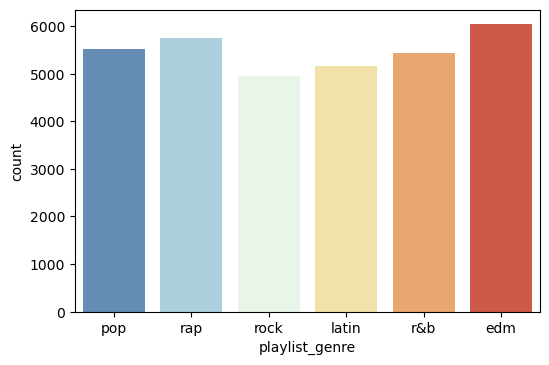

In [8]:
sns.countplot(x='playlist_genre', data=df_tbs, palette="RdYlBu_r")
plt.show()
plt.close()

The DataSet appears to be fairly well balanced between each `playlist_genre`. With biased data sets, ML algorithms perform poorly because they tend to simply predict the majority class in all cases. We can now focus on each non-categorical feature and its values regarding the `playlist_genre`. 

#### **1.5.2 Features density for each playlist genre** <a class="anchor" id="sub_section_1_5_2"></a>

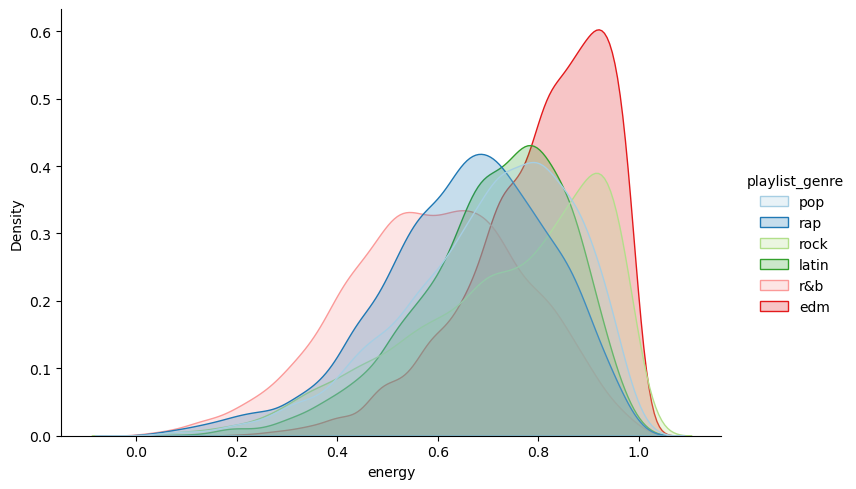

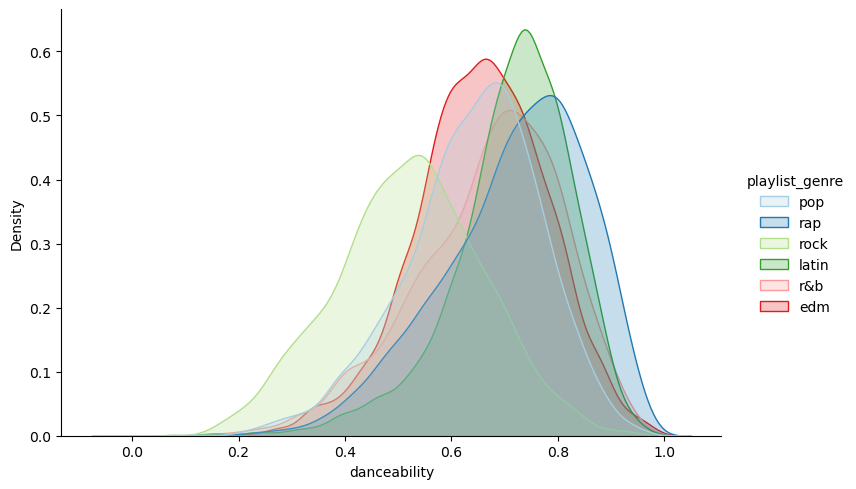

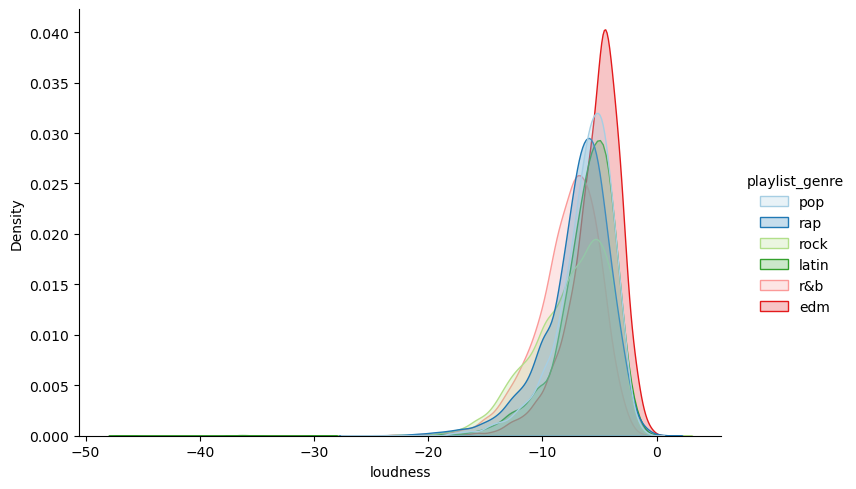

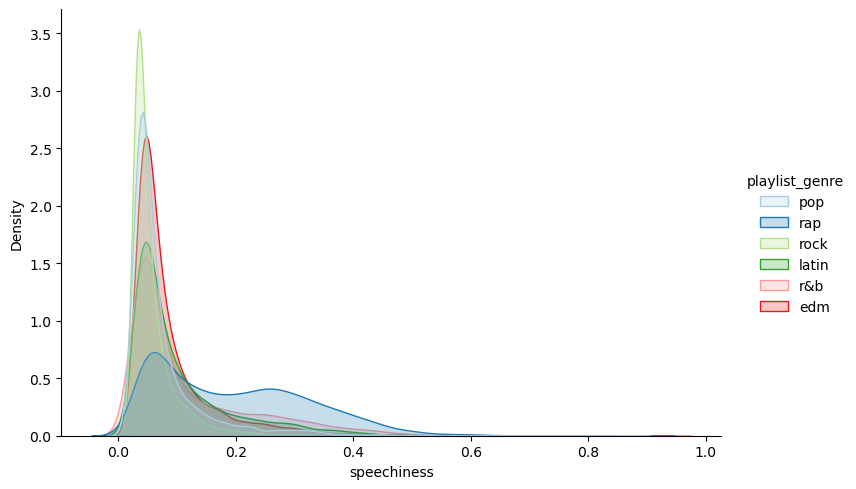

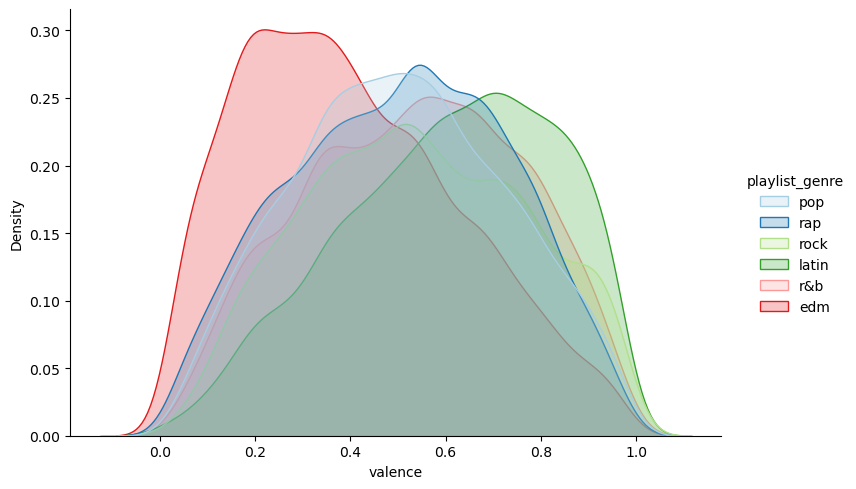

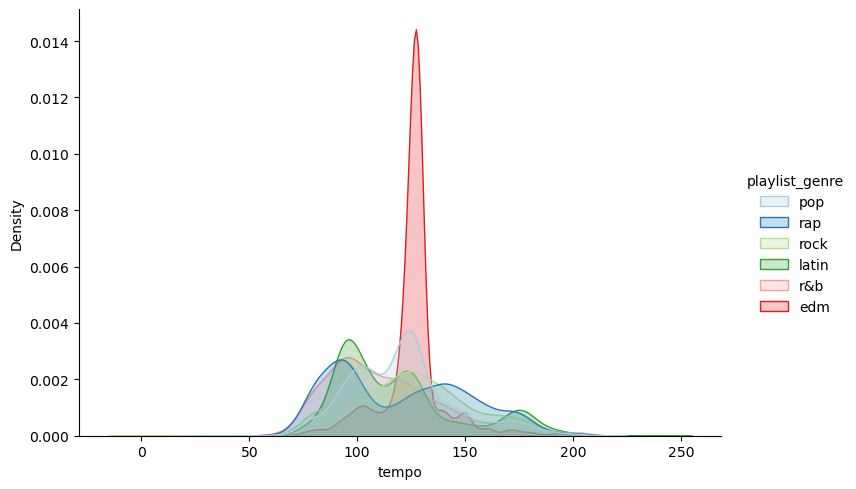

In [9]:
density_features = ['energy', 'danceability', 'loudness', 'speechiness', 'valence', 'tempo']

for feature in density_features: 
    sns.displot(data=df, x=feature, hue='playlist_genre', kind='kde', fill=True, palette='Paired', height=5, aspect=1.5)

plt.show()
plt.close()

With the exception of the `tempo` characteristic, the distribution of values seems quite similar, with no particular deviation. This is not a surprise since the genres represented in the dataset are close (the genres `edm`, `pop` and `latin` are often confused!). This similarity of values makes our classification task more complex. Eventually, it would be interested to check for any correlation between our non-categorical features :

#### **1.5.3 Correlation between features**<a class="anchor" id="sub_section_1_5_2"></a>

To evaluate the correlations between our non-categorical features we'll plot a heatmap using [seaborn](https://seaborn.pydata.org) library. 

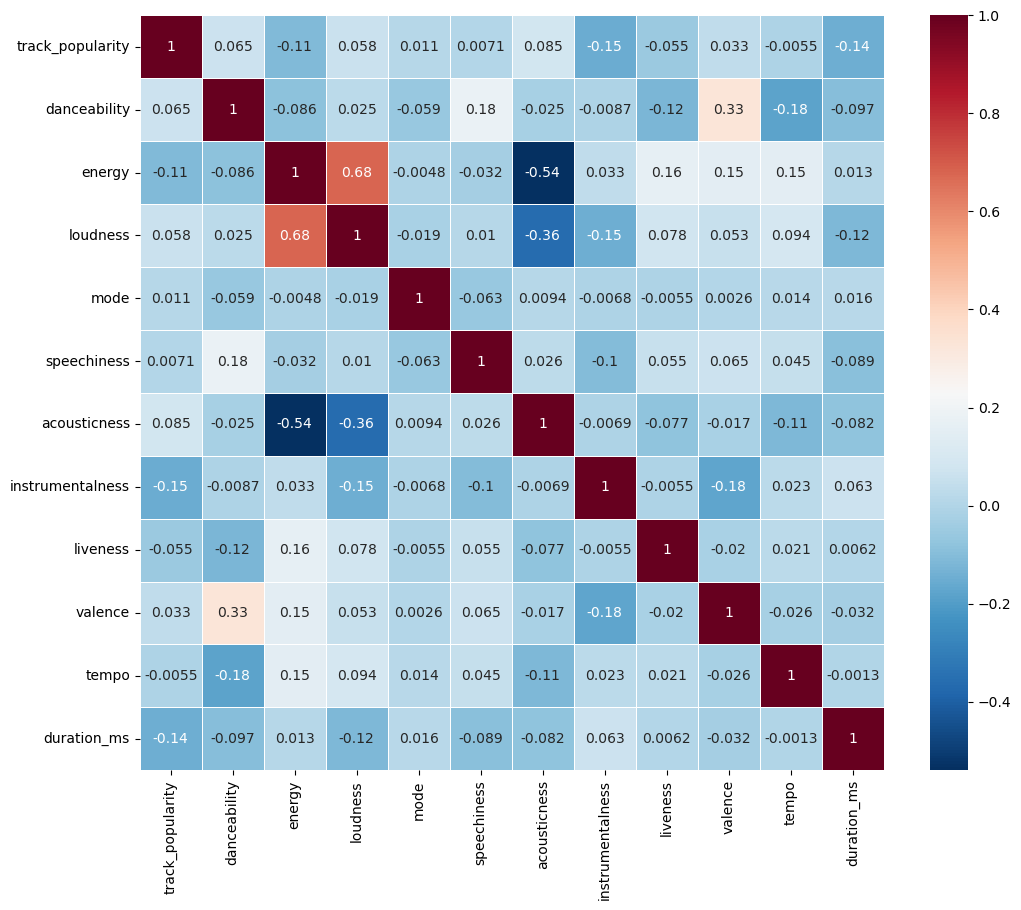

In [10]:
plt.figure(figsize=(12,10))
sns.heatmap(df_trimmed.corr(), annot=True, linewidths=.5,  cmap="RdBu_r")

plt.show()
plt.close()

We can make multiple observations on this graph :
* `energy` is positively correlated with `loudness` : this is not a surprise since the perceived loudness is used in the calculation of the overall energy of a song.
* `valence` is positively correlated with `danceability` : a positive song is more likely to make you dance than a sad song!
* `accousticness` is negatively correlated with `energy` : unlike electro, acoustic songs use mostly "acoustic" instruments. Overall, they tend to have a low intensity and therefore a low `energy`.
* the rest of the features have little to no correlation: this tends to complicate the downscaling process (dimensional reduction).

### 1.6 Normalizing the Data <a class="anchor" id="section_1_6"></a>

Since these data have a diverse range of features and no obvious Gaussian distribution, we will apply a normalization process to them giving each feature an equal weight. To do this, we will use the prebuilt functions of the [sklearn](https://scikit-learn.org/stable/) library. 

We will use the `MaxAbsScaler()` : _"This estimator scales and translates each feature individually such that the maximal absolute value of each feature in the training set will be 1.0. It does not shift/center the data, and thus does not destroy any sparsity."_

In [11]:
# Compute maximum absolute value per feature.
abs_scaler = MaxAbsScaler()
abs_scaler.fit(df_tbs.drop(['playlist_genre', 'playlist_subgenre'], axis=1))

# Transform the data using the maximum absolute values as calculated by the fitting method.
scaled_features = abs_scaler.transform(df_tbs.drop(['playlist_genre', 'playlist_subgenre'], axis=1))

# Store the results in a data frame
scaled_data = pd.DataFrame(scaled_features, columns = df_tbs.drop(['playlist_genre', 'playlist_subgenre'], axis=1).columns)

### 1.7 Final dataframe <a class="anchor" id="section_1_7"></a>

We can now compute the final data frame that we will use for our ML algorithms. We then summarize the features included in our `df_final.` file.

In [12]:
df_final = pd.concat([scaled_data, df_ohe[['playlist_genre', 'playlist_subgenre']]], axis=1)
df_final.dropna(inplace=True)
df_final.head(3)

,key_A,key_A#,key_B,key_C,key_C#,key_D,key_D#,key_E,key_F,key_F#,...,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,playlist_genre,playlist_subgenre
0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.063508,0.102616,0.000000,0.065562,0.522704,0.509673,0.376111,pop,dance pop
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,1.0,0.040632,0.072837,0.004235,0.358434,0.699294,0.417524,0.314015,pop,dance pop
2,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.080828,0.079879,0.000023,0.110442,0.618567,0.517908,0.341083,pop,dance pop


#### **1.7.1 Final DataFrame - Features Overview** <a class="anchor" id="sub_section_1_7_1"></a>
_Note that all the non-categorical values are now normalized._
|   Variable   | Class | Description   |
|---    |:-:    |---    |
|track_popularity|double|Song Popularity (0-100) where higher is better|
|track_album_release_season_{_season_}|boolean (OHE)|Season when the album was released|
|playlist_genre|character (Main Target)|Playlist genre|
|playlist_subgenre|character (Sub Target)|Playlist subgenre|
|danceability|double|Danceability describes how suitable a track is for dancing based on a combination of musical elements including tempo, rhythm stability, beat strength, and overall regularity. A value of 0.0 is least danceable and 1.0 is most danceable.|
|energy|double|Energy is a measure from 0.0 to 1.0 and represents a perceptual measure of intensity and activity. Typically, energetic tracks feel fast, loud, and noisy. For example, death metal has high energy, while a Bach prelude scores low on the scale. Perceptual features contributing to this attribute include dynamic range, perceived loudness, timbre, onset rate, and general entropy.|
|key_{_key_}|boolean (OHE)|The estimated overall key of the track. Integers map to pitches using standard Pitch Class notation.|
|loudness|double|The overall loudness of a track in decibels (dB). Loudness values are averaged across the entire track and are useful for comparing relative loudness of tracks. Loudness is the quality of a sound that is the primary psychological correlate of physical strength (amplitude). Values typical range between -60 and 0 db.|
|mode|double|	Mode indicates the modality (major or minor) of a track, the type of scale from which its melodic content is derived. Major is represented by 1 and minor is 0.|
|speechiness|double|	Speechiness detects the presence of spoken words in a track. The more exclusively speech-like the recording (e.g. talk show, audio book, poetry), the closer to 1.0 the attribute value. Values above 0.66 describe tracks that are probably made entirely of spoken words. Values between 0.33 and 0.66 describe tracks that may contain both music and speech, either in sections or layered, including such cases as rap music. Values below 0.33 most likely represent music and other non-speech-like tracks.|
|acousticness|double|A confidence measure from 0.0 to 1.0 of whether the track is acoustic. 1.0 represents high confidence the track is acoustic.|
|instrumentalness|double|Predicts whether a track contains no vocals. “Ooh” and “aah” sounds are treated as instrumental in this context. Rap or spoken word tracks are clearly “vocal”. The closer the instrumentalness value is to 1.0, the greater likelihood the track contains no vocal content. Values above 0.5 are intended to represent instrumental tracks, but confidence is higher as the value approaches 1.0.|
|liveness|double|Detects the presence of an audience in the recording. Higher liveness values represent an increased probability that the track was performed live. A value above 0.8 provides strong likelihood that the track is live.|
|valence|double|A measure from 0.0 to 1.0 describing the musical positiveness conveyed by a track. Tracks with high valence sound more positive (e.g. happy, cheerful, euphoric), while tracks with low valence sound more negative (e.g. sad, depressed, angry).|
|tempo|double|The overall estimated tempo of a track in beats per minute (BPM). In musical terminology, tempo is the speed or pace of a given piece and derives directly from the average beat duration.|
|duration_ms|double|Duration of song in milliseconds|


***

## 2. Baseline classification approach - Naive Bayes Classifier <a class="anchor" id="chapter2"></a>

In statistics, naive Bayes classifiers are referred to as simple probabilistic classifiers. These models rely on the application of Bayes' theorem assuming that the features are independant from one another (main assumption of the Bayes classifier). They are among the simplest Bayesian network models.

As seen in the [data visualization](#section_1_5), most of the features have [zero or no correlation](#sub_section_1_5_2) (independence assumption). We have a total of [six features](#sub_section_1_5_3) with continuous values whose plot reminds us of Gaussian distributions. Therefore, an appropriate Bayes classifier would be the Bayes naive Gaussian. We will use the model results as a baseline for improvement in our project.

### 2.1 Train and Test DataSets <a class="anchor" id="section_2_1"></a>

We divide our data into two subsets: one for training our model and another that will be used to test the trained model. We also identify the feature that will be our target class: in this case, `playlist_genre`. 
* 70% of the DataSet will be used for training
* 30% of the DataSet will be used for testing.

_Note : the tracks for each subset are randomly selected, the percentages are arbitrarily chosen._

In [16]:
x = df_final.drop(['playlist_subgenre','playlist_genre'], axis=1)
y = df_final['playlist_genre']

x_training_data, x_test_data, y_training_data, y_test_data = train_test_split(x, y, test_size = 0.3)

### 2.2 Bayes naive Gaussian <a class="anchor" id="section_2_1"></a>

In [60]:
# Training and testing our model on the DataSet
model = GaussianNB()
model.fit(x_training_data, y_training_data)
predictions = model.predict(x_test_data)

# Plotting the classification report of our prediction
print("=== Classification Report ===")
print(classification_report(y_test_data, predictions))

=== Classification Report ===
              precision    recall  f1-score   support

         edm       0.53      0.57      0.55      1802
       latin       0.33      0.31      0.32      1531
         pop       0.27      0.19      0.22      1685
         r&b       0.38      0.33      0.35      1623
         rap       0.47      0.47      0.47      1718
        rock       0.38      0.55      0.45      1488

    accuracy                           0.40      9847
   macro avg       0.39      0.40      0.39      9847
weighted avg       0.40      0.40      0.40      9847



Let us examine the results of our basic model. The accuracy of our model varies between $0.55$ and $0.30$ for each music genre. This is not bad considering that we have 6 possibilities for each prediction ($16\%$ chance by choosing completely at random). We get a computation time of $0.3s$ and a weighted average of $0.41$. These will be the results to improve throughout this notebook.

***

## 3. First classification approach - Knn method <a class="anchor" id="chapter3"></a>

A first approach for solving our problematic is to use the Knn (K-Nearest Neighbors) method. Knn is a classification algorithm that assumes that similar points can be found close to each other (when calculating the distance between features). In this case, we will use the Euclidean distance:
$$d(x, y) = \sum_{i=1}^n(x_i-y_i)^2$$
_Note : Hence the importance of having [normalised](#section_1_6) our data to avoid giving too much weight to certain features._

### 3.1 Knn-model (n_neighbors = 3) <a class="anchor" id="section_3_1"></a>

To get a first impression of the accuracy of such a model, we apply it with `n_neighbors = 3`. We then compute the accuracy of our prediction for each musical genre and the weighted average accuracy for all musical genres.

In [61]:
# Training and testing our model on the DataSet
model = KNeighborsClassifier(n_neighbors = 3)
model.fit(x_training_data, y_training_data)
predictions = model.predict(x_test_data)

# Plotting the classification report of our prediction
print("=== Classification Report ===")
print(classification_report(y_test_data, predictions))

=== Classification Report ===
              precision    recall  f1-score   support

         edm       0.37      0.65      0.47      1802
       latin       0.27      0.38      0.31      1531
         pop       0.24      0.23      0.24      1685
         r&b       0.36      0.22      0.28      1623
         rap       0.50      0.27      0.35      1718
        rock       0.59      0.37      0.45      1488

    accuracy                           0.36      9847
   macro avg       0.39      0.35      0.35      9847
weighted avg       0.39      0.36      0.35      9847



For `n_neighbors = 3`, we get a weighted average accuracy of $39\%$. Let's see if we can improve the accuracy by adjusting some of the HyperParameters. We will focus on `n_neighbors`.

### 3.2 Tuning the HyperParameters of our model <a class="anchor" id="section_3_2"></a>

In this section, we will test our model for different values of `n_neighbors` and try to calculate the one that maximizes the weighted average accuracy. The value of `n_neighbors` is crucial when reaching a good model, it is implicitely related to the error rate of the model. A small value of `n_neighbors` could lead to overfitting. However a too big value for `n_neighbors` could lead to underfitting. 

Overfitting means that the model performs well on training data, but performs poorly when given new data. Underfitting refers to models that perform poorly on both the training data and the new data.

n_neighbors optimizing weighted average precision: 13


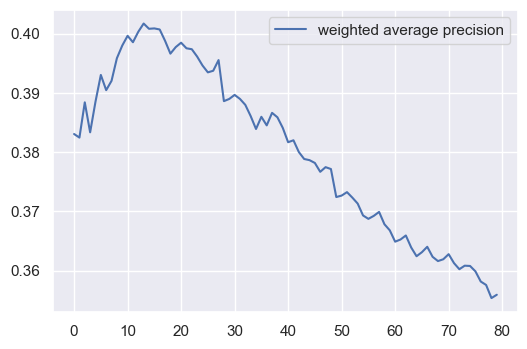

In [22]:
# We train our model with n_neighbors varying between 1 and 80
precision_weighted_avg = []
for i in np.arange(1, 81):
    new_model = KNeighborsClassifier(n_neighbors = i)
    new_model.fit(x_training_data, y_training_data)
    new_predictions = new_model.predict(x_test_data)
    precision_weighted_avg.append(classification_report(y_test_data, new_predictions, output_dict=True).get('weighted avg').get('precision'))

# Plotting the evolution of the weighted average precision 
sns.set_theme(style="darkgrid")
df_precision = pd.DataFrame(precision_weighted_avg, columns=['weighted average precision'])
df_precision.head(5)

sns.lineplot(data=df_precision)

# Computing n_neighbors maximizing the weighted average precision 
n_max = precision_weighted_avg.index(max(precision_weighted_avg))
print('n_neighbors optimizing weighted average precision:',n_max)

We now compute the accuracy of our prediction using `n_neighbors = n_max` and then compare the results with our first approach.

In [63]:
# Training and testing our model on the DataSet
model_opt = KNeighborsClassifier(n_neighbors = n_max)
model_opt.fit(x_training_data, y_training_data)
predictions_opt = model_opt.predict(x_test_data)

# Computing the classification report of our prediction
print("=== Classification Report ===")
print(classification_report(y_test_data, predictions_opt))

=== Classification Report ===
              precision    recall  f1-score   support

         edm       0.44      0.63      0.51      1802
       latin       0.30      0.36      0.33      1531
         pop       0.26      0.28      0.27      1685
         r&b       0.35      0.30      0.32      1623
         rap       0.51      0.34      0.40      1718
        rock       0.54      0.38      0.45      1488

    accuracy                           0.38      9847
   macro avg       0.40      0.38      0.38      9847
weighted avg       0.40      0.38      0.38      9847



Compared to the baseline, our prediction did not improve. The accuracy even decreased! This first approach using the knn method seems limited. We can now explore a second approach using decision trees.

***

## 4. Second classification approach - Decision Trees <a class="anchor" id="chapter4"></a>

Decision trees offer a second approach to classification. A decision tree is essentially a model that predicts the value of a target using decision rules deduced from the characteristics of the data.

Before we get to work, we can make an initial decision about the criterion we will use to compute the decision trees. When splitting a node, decision trees can use two different criterions : `entropy` and `giny`. 
$$ \text{Giny} = 1-\sum_{j=1}^n p_j^2$$
$$ \text{Entropy} = -\sum_{j=1}^n\text{log}_2(p_j)p_j$$

In the following parts of the project we will have to calculate a large number of decision trees. `entropy` takes a bit longer to calculate because it uses logarithms. In order to limit the computation time, we will therefore use the `giny` criterion.


#### 4.1 Decision Tree <a class="anchor" id="section_4_1"></a>

Let's train a decision tree on our data and see how it performs against our previous Gaussian bayes Classifier. In this first example, we have arbitrarily chosen the Hyper parameters to use as a baseline when tuning the Hyper parameters.

=== Decision Tree ===


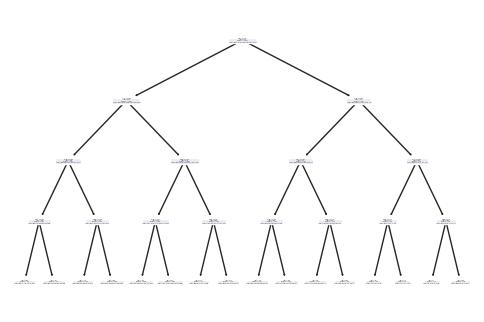

=== Classification Report ===
              precision    recall  f1-score   support

         edm       0.57      0.39      0.46      1802
       latin       0.24      0.48      0.32      1531
         pop       0.00      0.00      0.00      1685
         r&b       0.32      0.32      0.32      1623
         rap       0.42      0.60      0.50      1718
        rock       0.51      0.50      0.51      1488

    accuracy                           0.38      9847
   macro avg       0.34      0.38      0.35      9847
weighted avg       0.34      0.38      0.35      9847



In [64]:
# Training and testing our Decision Tree on the DataSet
decision_tree = DecisionTreeClassifier(criterion = "gini", random_state = 100, max_depth=4, min_samples_leaf=5)
decision_tree.fit(x_training_data, y_training_data)
prediction_dt = decision_tree.predict(x_test_data)

# Plotting our trained Decision Tree
print("=== Decision Tree ===")
plot_tree(decision_tree)
plt.show()
plt.close()

# Computing the classification report of our prediction
print("=== Classification Report ===")
print(classification_report(y_test_data, prediction_dt))

The untuned decision tree performs very poorly ($0.00$ accuracy on genre `pop` and a weighted average of $0.35$). Its performance is worse than all our previous models, including the baseline method. However, it does well enough for the genres of `edm` and `rock`. 

The $0.00$ precision on the pop genre is quite intriguing. One hypothesis could be that the decision tree does not assign the `pop` genre when predicting.

A more accurate prediction could be obtained by combining the results of different decision trees. Let us try to implement the Random Forest method.

#### 4.2 Random Forest <a class="anchor" id="section_4_2"></a>

We first use a Random Forest classifier with the default Hyper Parameters and compare its performance to the previous classifiers methods. Our Forest will be composed of `n_estimators=100` trees (Default parameter).

In [21]:
# Training and testing our model on the DataSet
rdf_clf=RandomForestClassifier(n_estimators=100)
rdf_clf.fit(x_training_data,y_training_data)
rdf_predictions=rdf_clf.predict(x_test_data)

# Computing the classification report of our prediction
print("=== Classification Report ===")
print(classification_report(y_test_data, rdf_predictions))

=== Classification Report ===
              precision    recall  f1-score   support

         edm       0.66      0.70      0.68      1800
       latin       0.51      0.42      0.46      1522
         pop       0.37      0.31      0.34      1633
         r&b       0.47      0.48      0.48      1653
         rap       0.57      0.65      0.61      1724
        rock       0.68      0.74      0.71      1515

    accuracy                           0.55      9847
   macro avg       0.54      0.55      0.55      9847
weighted avg       0.54      0.55      0.55      9847



The weighted average accuracy increased from $39\%$ (adjusted knn method) to $54\%$ (unadjusted random forest). In addition to this, the top nodes of our random forest give us insight into the most important features for predicting a `playlist_genre`. These "important" features will be particularly useful when we'll try to create our own clusters with the DataSet. We will see in the following section how we can retrieve those precious informations.

#### 4.3 Identifying key features <a class="anchor" id="section_4_3"></a>

We will try to identify and plot the key features of our DataSet using the built-in functions of the [sklearn](https://scikit-learn.org/stable/) library.

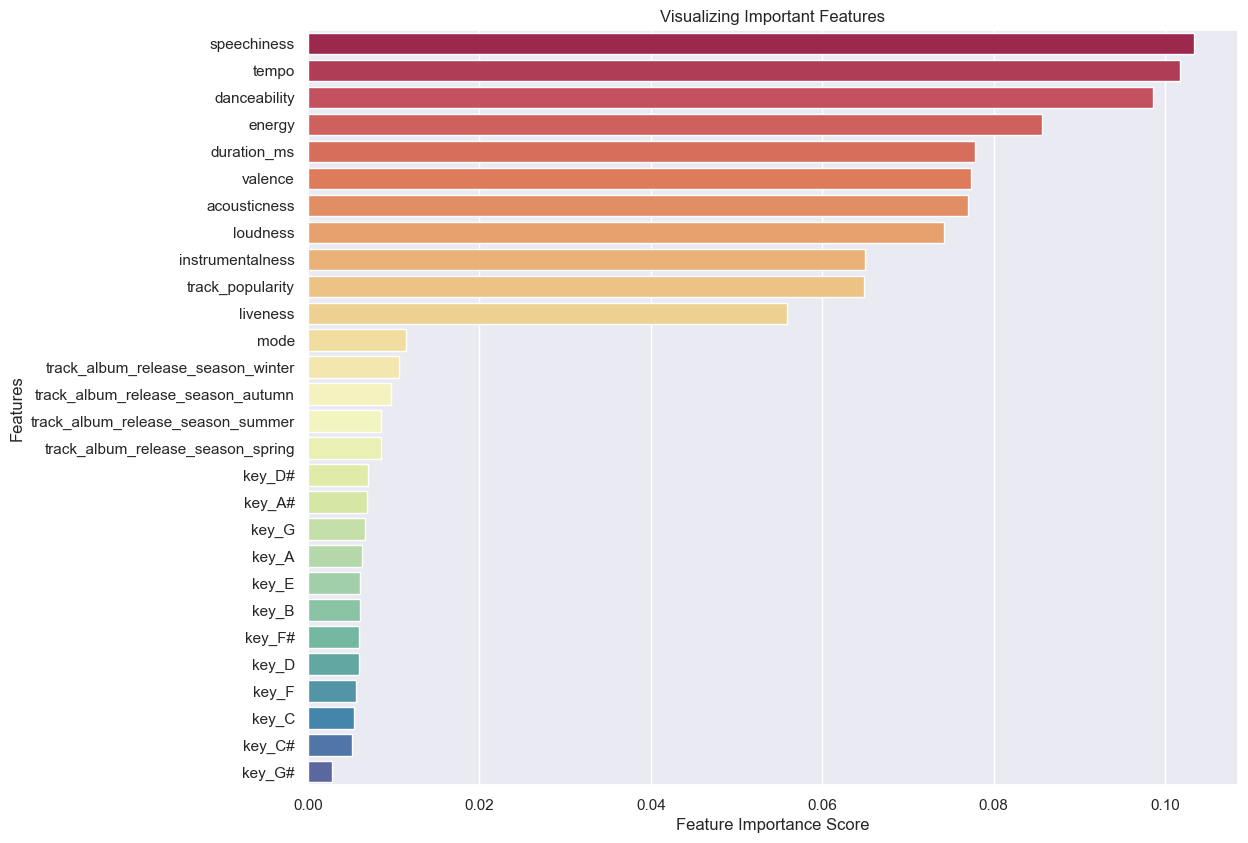

In [66]:
# Computing Feature importance scores
feature_imp = pd.Series(rdf_clf.feature_importances_, index=x_test_data.columns.unique()).sort_values(ascending=False)

# Plotting the scores
plt.figure(figsize=(12,10))

sns.barplot(x=feature_imp, y=feature_imp.index, palette='Spectral')
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing Important Features")

plt.show()
plt.close()

We observe that the $17$ least important features each score less than $1\%$. Let's try to remove them to see if they are more misleading than useful. We can now recompute our model without those features.

=== Classification Report ===
              precision    recall  f1-score   support

         edm       0.65      0.69      0.67      1814
       latin       0.49      0.38      0.43      1589
         pop       0.35      0.33      0.34      1604
         r&b       0.47      0.46      0.46      1586
         rap       0.58      0.65      0.61      1776
        rock       0.68      0.75      0.71      1478

    accuracy                           0.55      9847
   macro avg       0.54      0.54      0.54      9847
weighted avg       0.54      0.55      0.54      9847



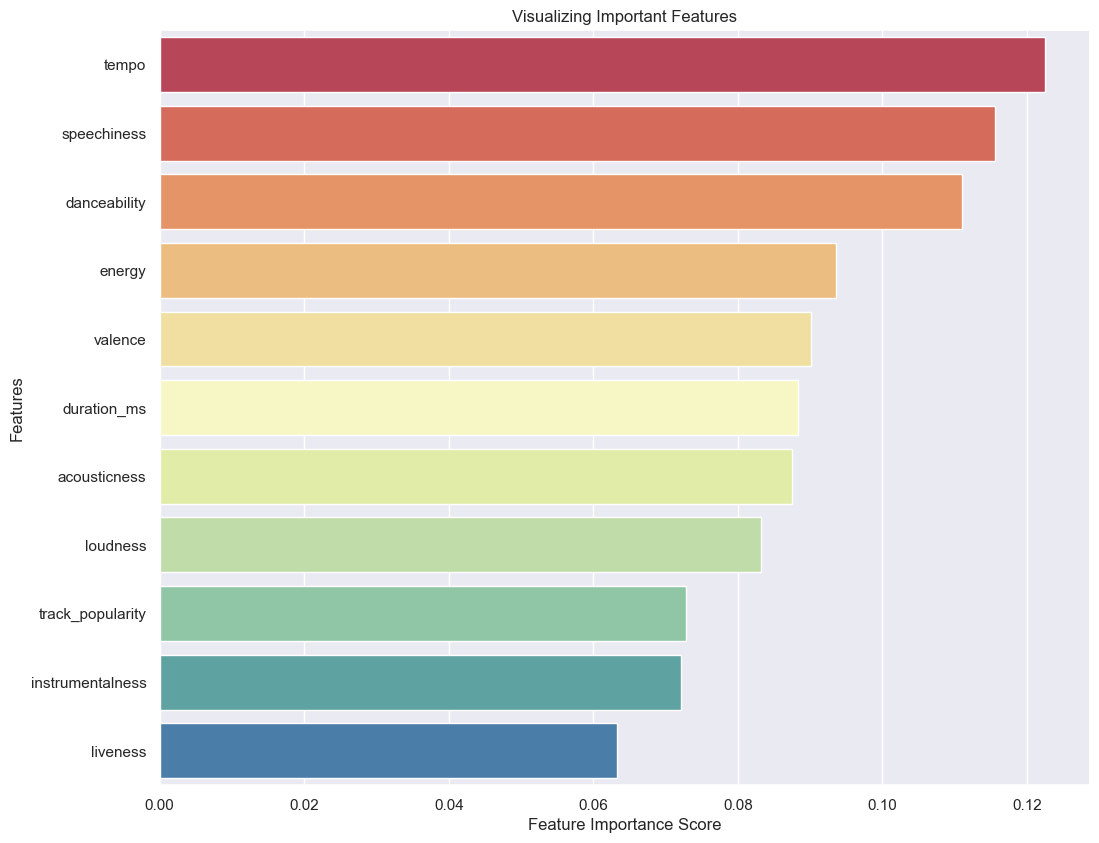

In [67]:
# We recompute our Train and Test subsets
least_important_features = ['key_A#', 'key_D#', 'key_A', 'key_G', 'key_D', 'key_F#', 'key_E', 'key_B', 'key_F', 'key_C', 'key_C#', 'key_G#',
                        'track_album_release_season_autumn', 'track_album_release_season_summer','track_album_release_season_spring', 'track_album_release_season_winter',
                        'mode']

x_trm = df_final.drop(least_important_features+['playlist_subgenre','playlist_genre'], axis=1)
y_trm = df_final['playlist_genre']

x_training_data_trm, x_test_data_trm, y_training_data_trm, y_test_data_trm = train_test_split(x_trm, y_trm, test_size = 0.3)

# Training and testing our model on the DataSet
clf=RandomForestClassifier(n_estimators=100)
clf.fit(x_training_data_trm, y_training_data_trm)

# Computing the classification report of our prediction
print("=== Classification Report ===")
rdf_predictions=clf.predict(x_test_data_trm)
print(classification_report(y_test_data_trm, rdf_predictions))

# Plotting the scores
plt.figure(figsize=(12,10))

feature_imp = pd.Series(clf.feature_importances_, index=x_test_data_trm.columns.unique()).sort_values(ascending=False)
sns.barplot(x=feature_imp, y=feature_imp.index, palette='Spectral')

plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing Important Features")

plt.show()
plt.close()

Our weighted average accuracy was virtually unchanged. We can conclude that these $17$ features had little to no importance in the classification of the tracks. We could remove them to save computational time. As we did with the knn method, let's see if we can adjust the Hyper Parameters of our classifier to maximize its accuracy.

#### 4.4 Tuning the HyperParameters : Random Cross Validation <a class="anchor" id="section_4_4"></a>

##### **Cross Validation**
This time, we will use the entire data set to train our model using the cross-validation method. Instead of simply dividing our data into a training subset and a test subset, we will divide it into $k$ parts of equal size. These subsets are called folds. K-Fold cross-validation consists of using one fold as `test_data` and the rest as `training_data` and repeating the process for each fold. We finally average the performance we obtained using each fold individually as our test subset.

##### **Random Cross Validation**
Let's take a closer look at the HyperParameters we can play with for a random forest :


In [13]:
clf=RandomForestClassifier()
print("=== Random Forest - HyperParameters ===")
print(clf.get_params())

=== Random Forest - HyperParameters ===
{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False}


We observe many more parameters than we had for our simple knn method. Testing all combinations as we did in [2.3](#subset_2_3) would take too much time. One way to do this is to use the random cross-validation of the [sklearn](https://scikit-learn.org/stable/) library. The principle is quite simple:
* we first define a HyperParameter grid containing approximate ranges where the optimal parameters could be found.
* We then randomly sample the grid
* For each random sample, we perform a K-Fold CV with our data set.

Let's first create our HyperParameter random grid :

In [14]:
# HyperParameters
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 2000, num = 10)] # The number of trees in the forest
max_features = ['auto', 'sqrt'] # The number of features to consider when looking for the best split
max_depth = [int(x) for x in np.linspace(10, 100, num = 10)] # The maximum depth of the tree
max_depth.append(None)
min_samples_split = [2, 5, 10] # The minimum number of samples required to split an internal node
min_samples_leaf = [1, 2, 4] # The minimum number of samples required to be at a leaf node
bootstrap = [True, False] # Whether bootstrap samples are used when building trees. If False, the whole dataset is used to build each tree

# Creating our Random Grid
hp_rd_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

print(hp_rd_grid)

{'n_estimators': [100, 311, 522, 733, 944, 1155, 1366, 1577, 1788, 2000], 'max_features': ['auto', 'sqrt'], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False]}


We can now train our Classifier using the previous random grid : 

**IMPORTANT**: the following code takes $64$ minutes to run. The best parameters have been calculated and are used in the following code.

In [17]:
## Training our model on the DataSet
rf_random = RandomizedSearchCV(estimator = clf, param_distributions = hp_rd_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
# rf_random.fit(x_training_data,y_training_data)

## Printing optimal HyperParameters
print(rf_random.best_params_)

Fitting 3 folds for each of 100 candidates, totalling 300 fits
{'n_estimators': 1788, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'auto', 'max_depth': 20, 'bootstrap': False}


Finally, we apply these optimal HyperParameters and check the improvement of our weighted average accuracy:

In [20]:
# Training and testing our tuned model on the DataSet
clf=RandomForestClassifier(n_estimators=1788, min_samples_split=5, min_samples_leaf=1, max_features='auto', max_depth=20, bootstrap=False)
clf.fit(x_training_data,y_training_data)
rdf_predictions=clf.predict(x_test_data)

# Computing the classification report of our prediction
print("=== Classification Report ===")
print(classification_report(y_test_data, rdf_predictions))

=== Classification Report ===
              precision    recall  f1-score   support

         edm       0.67      0.71      0.69      1800
       latin       0.51      0.42      0.46      1522
         pop       0.38      0.32      0.35      1633
         r&b       0.48      0.49      0.48      1653
         rap       0.58      0.67      0.62      1724
        rock       0.69      0.75      0.72      1515

    accuracy                           0.56      9847
   macro avg       0.55      0.56      0.55      9847
weighted avg       0.55      0.56      0.56      9847



Our weighted average accuracy has improved again! We gained about one percent over our untuned random forest model. We can see that improving our performance is increasingly complex and time consuming. We have to find a trade-off between efficiency and complexity of our model.

***

## 5. Clustering method - K-Means <a class="anchor" id="chapter5"></a>

### 5.1 Clustering on the original Data Set <a class="anchor" id="section_5_1"></a>

#### 5.1.1 Clustering with all of our parameters <a class="anchor" id="sub_section_5_1_1"></a>

We will now try to implement a clustering method on our data: **K-Means** clustering.  
First, we remove from our dataset the columns we are trying to predict.

In [18]:
X = df_final.drop(columns = ['playlist_genre','playlist_subgenre'])
X.head()

,key_A,key_A#,key_B,key_C,key_C#,key_D,key_D#,key_E,key_F,key_F#,...,energy,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms
0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.916,-0.056709,1.0,0.063508,0.102616,0.000000,0.065562,0.522704,0.509673,0.376111
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.815,-0.106980,1.0,0.040632,0.072837,0.004235,0.358434,0.699294,0.417524,0.314015
2,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.931,-0.073889,0.0,0.080828,0.079879,0.000023,0.110442,0.618567,0.517908,0.341083
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.930,-0.081338,1.0,0.111111,0.028873,0.000009,0.204819,0.279516,0.509338,0.326554
4,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.833,-0.100586,1.0,0.039107,0.080785,0.000000,0.083635,0.731584,0.517775,0.365099


As each iteration of a K-Mean algorithm produces a different result, we will run the algorithm ten times to get a better view of the possible performance that our K-Mean algorithm produces. 

In order to run the K-Mean algorithm, we will use the `KMeans` from `sklearn.cluster`. At each iteration, we will track the `adjusted_rand_score`, which calculates a similarity measure between two clusters by considering all sample pairs and counting the pairs that are assigned to the same or different clusters in the predicted and true clusters.   

The closer the result is to 1, the more identical the projected values are.

In [33]:
score_ls = []           
for i in range(10):
    kmeans = KMeans(n_clusters = 6, init='random', random_state=i, n_init=1)   
    df_final['pred'] = kmeans.fit_predict(X)
    print("Number of iterations: ", kmeans.n_iter_)
    score_ls.append(round(adjusted_rand_score(df_final['pred'], df_final['playlist_genre']), 4))
    #The score is added. The closer the score is to 1, the more the values are identical.
    print("-- score = ",score_ls[i])
    

Number of iterations:  4
-- score =  0.003
Number of iterations:  8
-- score =  0.0031
Number of iterations:  6
-- score =  0.0038
Number of iterations:  5
-- score =  0.0032
Number of iterations:  6
-- score =  0.0039
Number of iterations:  9
-- score =  0.0037
Number of iterations:  6
-- score =  0.0059
Number of iterations:  5
-- score =  0.0029
Number of iterations:  4
-- score =  0.0024
Number of iterations:  11
-- score =  0.0046


As we have several features, which means several dimensions, we need to restrict the dimension to 2 in order to be able to represent it in a graph.

To do this, we use the **PCA** algorithm.  
     
PCA is an unsupervised machine learning algorithm that attempts to reduce the dimensionality (number of features) of a data set while retaining as much information as possible. This is done by finding a new set of features called components, which are composites of the original uncorrelated features. They are also constrained so that the first component represents the greatest possible variability in the data, the second component the second greatest variability, and so on.

In [34]:
pca = PCA(n_components=2)
pca_X = pd.DataFrame(data=pca.fit_transform(X), columns=['pc1', 'pc2'])
print('Total variance explained: ', round(pca.explained_variance_ratio_.sum(), 4))
pca_X['true'] = df_final['playlist_genre'].values

Total variance explained:  0.2537


- We note that the variance of our two components describes only $25\%$ of the variance of the original dataset, which **is quite low**. This also shows us that much of the information retained by our parameters will not be represented.  
- We should also point out the low score we obtained using the K-Means algorithm. A score of $0.0028$ is extremely low, which tells us that we are unable to correctly predict musical genres.

In order to get a better performance, we will drop the columns we added to have a one-hot encoder since they have binary values, which compromises the performance of the PCA, and we will evaluate from there.

In [35]:
X2 = X.drop(columns = ['key_A', 'key_A#', 'key_B', 'key_C', 'key_C#', 'key_D', 'key_D#',
       'key_E', 'key_F', 'key_F#', 'key_G', 'key_G#',
       'track_album_release_season_autumn',
       'track_album_release_season_spring',
       'track_album_release_season_summer',
       'track_album_release_season_winter'])
X2.head()

,track_popularity,danceability,energy,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms
0,0.66,0.760936,0.916,-0.056709,1.0,0.063508,0.102616,0.000000,0.065562,0.522704,0.509673,0.376111
1,0.67,0.738555,0.815,-0.106980,1.0,0.040632,0.072837,0.004235,0.358434,0.699294,0.417524,0.314015
2,0.70,0.686673,0.931,-0.073889,0.0,0.080828,0.079879,0.000023,0.110442,0.618567,0.517908,0.341083
3,0.60,0.730417,0.930,-0.081338,1.0,0.111111,0.028873,0.000009,0.204819,0.279516,0.509338,0.326554
4,0.69,0.661241,0.833,-0.100586,1.0,0.039107,0.080785,0.000000,0.083635,0.731584,0.517775,0.365099


In [36]:
pca = PCA(n_components=2)
pca_X2 = pd.DataFrame(data=pca.fit_transform(X2), columns=['pc1', 'pc2'])
print('Total variance explained: ', round(pca.explained_variance_ratio_.sum(), 4))
pca_X2['true'] = df_final['playlist_genre'].values

Total variance explained:  0.5473


In [37]:
score_ls = []           
for i in range(10):
    kmeans = KMeans(n_clusters = 6, init='random', random_state=i, n_init=1)   
    df_final['pred'] = kmeans.fit_predict(X2)
    print("Number of iterations: ", kmeans.n_iter_)
    score_ls.append(round(adjusted_rand_score(df_final['pred'], df_final['playlist_genre']), 4))
    print(",  score = ",score_ls[i])
    #On ajoute le score. Plus le score se rapproche de 1, plus les valeurs sont identiques.

Number of iterations:  10
,  score =  0.0208
Number of iterations:  36
,  score =  0.0209
Number of iterations:  25
,  score =  0.0167
Number of iterations:  33
,  score =  0.0142
Number of iterations:  14
,  score =  0.0161
Number of iterations:  33
,  score =  0.0178
Number of iterations:  29
,  score =  0.0196
Number of iterations:  17
,  score =  0.0178
Number of iterations:  14
,  score =  0.0208
Number of iterations:  13
,  score =  0.0134


By doing this we can see that we have **doubled** our total variance and **multiplied our score by 10**, but it is still relatively low.
The improvement in PCA is due to the binary nature of the columns we have removed, but also to the fact that we have removed a large number of parameters, which means several dimensions. Therefore, it will be easier to reduce the dimensions and retain more information than before.

#### 5.1.2 Clustering with parameters with continuous values only <a class="anchor" id="sub_section_5_1_2"></a>

Now we will represent the distribution of the original data in a graph representing the 2 dimensions we have calculated, and the result of the clustering of our K-Means algorithm.

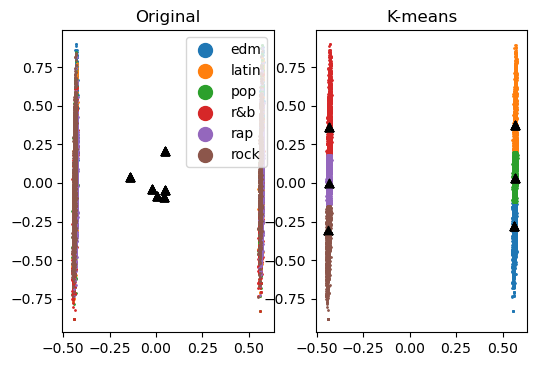

In [38]:
fig, (ax1, ax2) = plt.subplots(1, 2)

kmeans = KMeans(n_clusters = 6, init='random')
pca_X2['kmeans_pred'] = kmeans.fit_predict(pca_X2[['pc1', 'pc2']])

kmeans_centroids = kmeans.cluster_centers_

genres = np.unique(df_final['playlist_genre'].values)

true_centroids = np.array([[pca_X2.loc[pca_X2['true']==z, 'pc1'].mean(), 
                               pca_X2.loc[pca_X2['true']==z, 'pc2'].mean()] for z in genres])

for (genre,number) in zip(genres,np.arange(0,len(genres))) :
    ax1.scatter(pca_X2.loc[pca_X2['true']==genre, 'pc1'], pca_X2.loc[pca_X2['true']==genre, 'pc2'], s = 1, label = genre)
    ax1.set_title("Original")
    ax1.legend(markerscale=10, loc='upper right')
        # axs[k-2, 0].scatter(kmeans_centroids[:, 0], kmeans_centroids[:, 1], marker="^", color='black')
        #axs[k-2, 0].set_title("K-means")
    ax1.scatter(true_centroids[:, 0], true_centroids[:, 1], marker="^", color='black')
    ax2.scatter(pca_X2.loc[pca_X2['kmeans_pred']==number, 'pc1'], pca_X2.loc[pca_X2['kmeans_pred']==number, 'pc2'], s = 1)
    ax2.scatter(kmeans_centroids[:, 0], kmeans_centroids[:, 1], marker="^", color='black')
    ax2.set_title("K-means")

plt.show()
plt.close()

We see that we have obtained a strange result. The data are arranged around two vertical axes. In the original, we see that the data are mixed. There is no clear separation between the data, which makes the work of our algorithm much more difficult.  This is a problem that can be explained by the fact that the genres we have chosen are not very different for the most part. The difference is rather nuanced, which makes the work of our algorithm difficult.

#### 5.1.3 Clustering with parameters with the most important values <a class="anchor" id="sub_section_5_1_3"></a>

Earlier we tried to identify the most important features. In order to further reduce the dimensions while retaining enough information to help us identify the genres, we will try to run our algorithm only on the basis of these features.

In [39]:
X3 = df_final[['tempo','danceability','speechiness','energy']]
pca = PCA(n_components=2)
pca_X3 = pd.DataFrame(data=pca.fit_transform(X3), columns=['pc1', 'pc2'])
print('Total variance explained: ', round(pca.explained_variance_ratio_.sum(), 4))
pca_X3['true'] = df_final['playlist_genre'].values

Total variance explained:  0.7105


In [40]:
score_ls = []           
for i in range(10):
    kmeans = KMeans(n_clusters = 6, init='random', random_state=i, n_init=1)   
    df_final['pred'] = kmeans.fit_predict(X3)
    print("Number of iterations: ", kmeans.n_iter_)
    score_ls.append(round(adjusted_rand_score(df_final['pred'], df_final['playlist_genre']), 4))
    print(",  score = ",score_ls[i])
    #On ajoute le score. Plus le score se rapproche de 1, plus les valeurs sont identiques. 

Number of iterations:  44
,  score =  0.0749
Number of iterations:  62
,  score =  0.0723
Number of iterations:  27
,  score =  0.0683
Number of iterations:  30
,  score =  0.0742
Number of iterations:  37
,  score =  0.0684
Number of iterations:  70
,  score =  0.0749
Number of iterations:  69
,  score =  0.0712
Number of iterations:  23
,  score =  0.0745
Number of iterations:  29
,  score =  0.0679
Number of iterations:  42
,  score =  0.0691


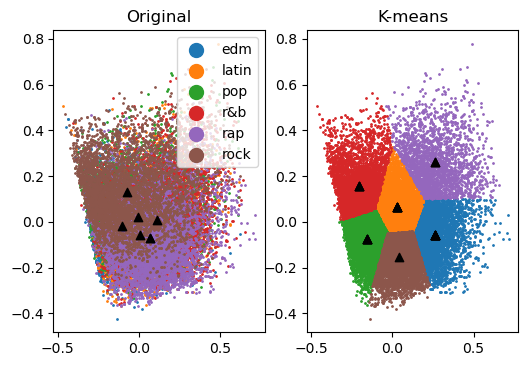

In [41]:
fig, (ax1, ax2) = plt.subplots(1, 2)

genres = np.unique(df_final['playlist_genre'].values)

pca_X3['kmeans_pred'] = kmeans.fit_predict(pca_X3[['pc1', 'pc2']])

kmeans_score = adjusted_rand_score(pca_X3['kmeans_pred'], pca_X3['true'])
kmeans_centroids = kmeans.cluster_centers_

genres = np.unique(df_final['playlist_genre'].values)

true_centroids = np.array([[pca_X3.loc[pca_X3['true']==z, 'pc1'].mean(), 
                               pca_X3.loc[pca_X3['true']==z, 'pc2'].mean()] for z in genres])

for (genre,number) in zip(genres,np.arange(0,len(genres))) :
    ax1.scatter(pca_X3.loc[pca_X3['true']==genre, 'pc1'], pca_X3.loc[pca_X3['true']==genre, 'pc2'], s = 1, label = genre)
    ax1.set_title("Original")
    ax1.legend(markerscale=10, loc='upper right')
        # axs[k-2, 0].scatter(kmeans_centroids[:, 0], kmeans_centroids[:, 1], marker="^", color='black')
        #axs[k-2, 0].set_title("K-means")
    ax1.scatter(true_centroids[:, 0], true_centroids[:, 1], marker="^", color='black')

    ax2.scatter(pca_X3.loc[pca_X3['kmeans_pred']==number, 'pc1'], pca_X3.loc[pca_X3['kmeans_pred']==number, 'pc2'], s = 1)
    ax2.scatter(kmeans_centroids[:, 0], kmeans_centroids[:, 1], marker="^", color='black')
    ax2.set_title("K-means")

plt.show()
plt.close()

#### 5.1.4 Clustering with a data_set of two highly distinct genres <a class="anchor" id="sub_section_5_1_4"></a>

Now we will try our algorithm on a dataset extracted from the previous one with two quite different genres: `r&b` and `rock`.

In [42]:
df_2 = df_final[df_final['playlist_genre'].isin(['r&b','rock']) ]
df_2.head()
print(np.unique(df_2['playlist_genre'].values))

['r&b' 'rock']


In [43]:
X4 = df_2[['tempo','danceability','speechiness','energy']]

score_ls = []           
for i in range(10):
    kmeans = KMeans(n_clusters = 2, init='random', random_state=i, n_init=1)   
    df_2['pred'] = kmeans.fit_predict(X4)
    print("Number of iterations: ", kmeans.n_iter_)
    score_ls.append(round(adjusted_rand_score(df_2['pred'], df_2['playlist_genre']), 4))
    print(",  score = ",score_ls[i])
#The score is added. The closer the score is to 1, the more the values are identical.

Number of iterations:  16
,  score =  0.1509
Number of iterations:  13
,  score =  0.1507
Number of iterations:  13
,  score =  0.1507
Number of iterations:  11
,  score =  0.1429
Number of iterations:  13
,  score =  0.1509
Number of iterations:  11
,  score =  0.1429
Number of iterations:  12
,  score =  0.1507
Number of iterations:  8
,  score =  0.1422
Number of iterations:  10
,  score =  0.1423
Number of iterations:  8
,  score =  0.142


With a much simpler data set, we will try to standardise our data and see if this makes any improvement.

In [44]:
std = StandardScaler()
std_X4 = pd.DataFrame(std.fit_transform(X4), 
                      index = X4.index, 
                      columns = X4.columns)

score_ls = []           
for i in range(10):
    kmeans = KMeans(n_clusters = 2, init='random', random_state=i, n_init=1)   
    df_2['pred'] = kmeans.fit_predict(std_X4)
    print("Number of iterations: ", kmeans.n_iter_)
    score_ls.append(round(adjusted_rand_score(df_2['pred'], df_2['playlist_genre']), 4))
    print(",  score = ",score_ls[i])
#On ajoute le score. Plus le score se rapproche de 1, plus les valeurs sont identiques.

Number of iterations:  5
,  score =  0.0451
Number of iterations:  20
,  score =  0.2525
Number of iterations:  13
,  score =  0.2513
Number of iterations:  9
,  score =  0.0452
Number of iterations:  13
,  score =  0.251
Number of iterations:  14
,  score =  0.2525
Number of iterations:  12
,  score =  0.251
Number of iterations:  11
,  score =  0.2533
Number of iterations:  16
,  score =  0.2513
Number of iterations:  12
,  score =  0.251


With the normalised data, we have doubled the performance of our algorithm, so we will keep it that way.

In [45]:
pca = PCA(n_components=2)
pca_X4 = pd.DataFrame(data=pca.fit_transform(std_X4), columns=['pc1', 'pc2'])
print('Total variance explained: ', round(pca.explained_variance_ratio_.sum(), 4))
pca_X4['true'] = df_2['playlist_genre'].values

Total variance explained:  0.6253


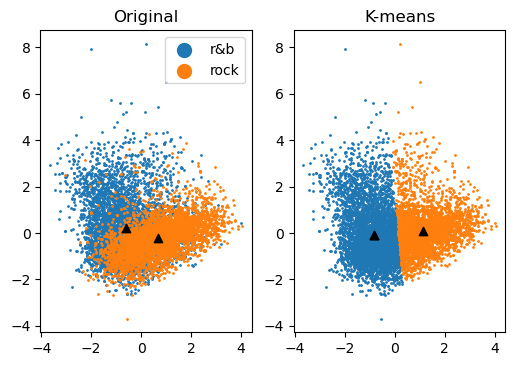

In [46]:
fig, (ax1, ax2) = plt.subplots(1, 2)

genres = np.unique(df_2['playlist_genre'].values)

#The centroid of the original data
true_centroids = np.array([[pca_X4.loc[pca_X4['true']==z, 'pc1'].mean(), 
                               pca_X4.loc[pca_X4['true']==z, 'pc2'].mean()] for z in genres])
#The K-Mean implementation
kmeans = KMeans(n_clusters = 2, init='random')
pca_X4['kmeans_pred'] = kmeans.fit_predict(pca_X4[['pc1', 'pc2']])

kmeans_score = adjusted_rand_score(pca_X4['kmeans_pred'], pca_X4['true'])

kmeans_centroids = kmeans.cluster_centers_


for (genre,number) in zip(genres,np.arange(0,len(genres))) :
    ax1.scatter(pca_X4.loc[pca_X4['true']==genre, 'pc1'], pca_X4.loc[pca_X4['true']==genre, 'pc2'], s = 1, label = genre)
    ax1.set_title("Original")
        # axs[k-2, 0].scatter(kmeans_centroids[:, 0], kmeans_centroids[:, 1], marker="^", color='black')
        #axs[k-2, 0].set_title("K-means")
    ax1.scatter(true_centroids[:, 0], true_centroids[:, 1], marker="^", color='black')
    ax1.legend(markerscale=10, loc='upper right')

    ax2.scatter(pca_X4.loc[pca_X4['kmeans_pred']==number, 'pc1'], pca_X4.loc[pca_X4['kmeans_pred']==number, 'pc2'], s = 1)
    ax2.scatter(kmeans_centroids[:, 0], kmeans_centroids[:, 1], marker="^", color='black')
    ax2.set_title("K-means")
plt.show()

We find that our algorithm manages to differentiate our two genres much more effectively. Even after preprocessing our data, it is still difficult for our algorithm to provide a definitive result, hence the score of $0.25$, which is not really good. The similarity between the genres in our dataset compromises the result of our algorithm. Therefore, we will use another dataset containing different genres, and we will try to look for a different result, and see if the results are more promising.

### 5.2 Clustering on a new Data Set <a class="anchor" id="section_5_2"></a>

We have seen that the similarities between the types of music make the K-mean method less effective in these situations. This time we will choose more different types of music. To do this, we introduce another dataset collected with the same API as the first one. But this time the genres will be much more distinct.

In [47]:
df_new = pd.read_csv('music_genre.csv')
df_new.head(3)

,instance_id,artist_name,track_name,popularity,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,obtained_date,valence,music_genre
0,32894.0,Röyksopp,Röyksopp's Night Out,27.0,0.00468,0.652,-1.0,0.941,0.7920,A#,0.115,-5.201,Minor,0.0748,100.889,4-Apr,0.759,Electronic
1,46652.0,Thievery Corporation,The Shining Path,31.0,0.01270,0.622,218293.0,0.890,0.9500,D,0.124,-7.043,Minor,0.0300,115.00200000000001,4-Apr,0.531,Electronic
2,30097.0,Dillon Francis,Hurricane,28.0,0.00306,0.620,215613.0,0.755,0.0118,G#,0.534,-4.617,Major,0.0345,127.994,4-Apr,0.333,Electronic


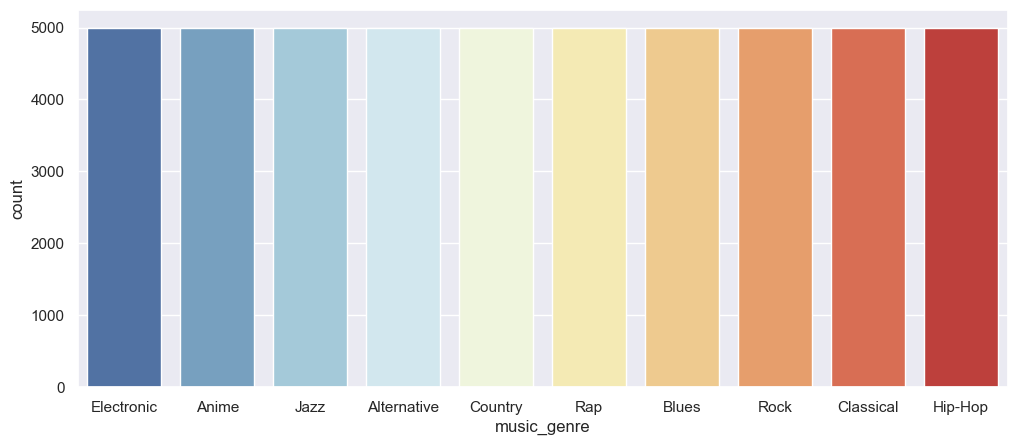

In [48]:
plt.figure(figsize=(12,5))
sns.countplot(x='music_genre', data=df_new, palette="RdYlBu_r")
plt.show()
plt.close()

We select four genres that are not too similar.

In [49]:
df_new = df_new[df_new['music_genre'].isin(['Anime', 'Classical', 'Hip-Hop', 'Blues'])]
df_new.dropna()
df_new = df_new.drop(columns=['instance_id', 'obtained_date', 'artist_name', 'track_name', 'key'])
df_new.dtypes

popularity          float64
acousticness        float64
danceability        float64
duration_ms         float64
energy              float64
instrumentalness    float64
liveness            float64
loudness            float64
mode                 object
speechiness         float64
tempo                object
valence             float64
music_genre          object
dtype: object

We see that there are some parameters that are stored with an object type. Let's correct this.

In [51]:
# Drop outliers
drop_index = df_new[(df_new['duration_ms']==-1) | (df_new['tempo']=='?')].index
df_new.drop(index = drop_index, inplace=True)

# Label encoding for music_genre
le = LabelEncoder()
df_new['music_genre'] = le.fit_transform(df_new['music_genre'])
df_new['mode'] = le.fit_transform(df_new['mode'])
df_new['tempo'] = np.round(df_new['tempo'].astype(float), 3)
A = df_new.drop(columns=['music_genre'])

# Standardize all columns except for target
std = StandardScaler()
std_A = pd.DataFrame(std.fit_transform(A), 
                      index = A.index, 
                      columns = A.columns)

# Plotting the first 3 rows of our final Data Frame
df_new.head(3)

,popularity,acousticness,danceability,duration_ms,energy,instrumentalness,liveness,loudness,mode,speechiness,tempo,valence,music_genre
5000,11.0,0.01540,0.362,429560.0,0.456,0.02410,0.2580,-11.355,1,0.0376,117.634,0.332,0
5002,29.0,0.00857,0.643,234874.0,0.966,0.00331,0.2550,-3.902,1,0.0442,131.982,0.912,0
5004,50.0,0.01450,0.567,268333.0,0.300,0.00000,0.0687,-8.421,1,0.0291,141.819,0.196,0


We try several implementations of the K-Mean algorithm to see the multiple scores that can be obtained.

In [51]:
std = StandardScaler()
std_A = pd.DataFrame(std.fit_transform(A), 
                      index = A.index, 
                      columns = A.columns)

score_ls = []           
for i in range(10):
    kmeans = KMeans(n_clusters = 4, init='random', random_state=i, n_init=1)   
    df_new['pred'] = kmeans.fit_predict(std_A)
    print("Number of iterations: ", kmeans.n_iter_)
    score_ls.append(round(adjusted_rand_score(df_new['pred'], df_new['music_genre']), 4))
    print("-- score = ",score_ls[i])
#The score is added. The closer the score is to 1, the more the values are identical.

Number of iterations:  23
-- score =  0.4646
Number of iterations:  15
-- score =  0.4645
Number of iterations:  20
-- score =  0.3626
Number of iterations:  27
-- score =  0.4772
Number of iterations:  29
-- score =  0.372
Number of iterations:  12
-- score =  0.3766
Number of iterations:  35
-- score =  0.4662
Number of iterations:  23
-- score =  0.4431
Number of iterations:  20
-- score =  0.4768
Number of iterations:  18
-- score =  0.4744


In [52]:
pca = PCA(n_components=2)
pca_A = pd.DataFrame(data=pca.fit_transform(std_A), columns=['pc1', 'pc2'])
print('Total variance explained: ', round(pca.explained_variance_ratio_.sum(), 4))
pca_A['true'] = df_new['music_genre'].values

Total variance explained:  0.4851


We notice some far more interesting results here. First, we have $0.4$ for K-Means and a variance equal to $0.48$ despite the Hyper Parameters we have.

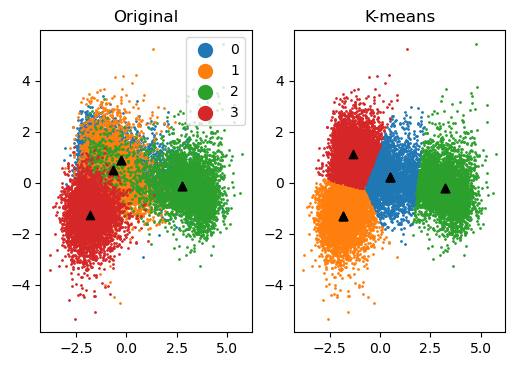

In [53]:
fig, (ax1, ax2) = plt.subplots(1, 2)

genres = np.unique(df_new['music_genre'].values)

#The centroid of the original data
true_centroids = np.array([[pca_A.loc[pca_A['true']==z, 'pc1'].mean(), 
                               pca_A.loc[pca_A['true']==z, 'pc2'].mean()] for z in genres])
#The K-Mean implementation
kmeans = KMeans(n_clusters = 4, init='random')
pca_A['kmeans_pred'] = kmeans.fit_predict(pca_A[['pc1', 'pc2']])

kmeans_score = adjusted_rand_score(pca_A['kmeans_pred'], pca_A['true'])

kmeans_centroids = kmeans.cluster_centers_


for number in np.arange(0,len(genres)) :

    ax1.scatter(pca_A.loc[pca_A['true']==number, 'pc1'], pca_A.loc[pca_A['true']==number, 'pc2'], s = 1,label = genres[number])
    ax1.set_title("Original")
        # axs[k-2, 0].scatter(kmeans_centroids[:, 0], kmeans_centroids[:, 1], marker="^", color='black')
        #axs[k-2, 0].set_title("K-means")
    ax1.scatter(true_centroids[:, 0], true_centroids[:, 1], marker="^", color='black')
    ax1.legend(markerscale=10, loc='upper right')

    ax2.scatter(pca_A.loc[pca_A['kmeans_pred']==number, 'pc1'], pca_A.loc[pca_A['kmeans_pred']==number, 'pc2'], s = 1)
    ax2.scatter(kmeans_centroids[:, 0], kmeans_centroids[:, 1], marker="^", color='black')
    ax2.set_title("K-means")
plt.show()

Even if we have a better result, in reality, a PCA algorithm is reliable when its variance is higher than $80\%$, which is not the case here. Moreover, our K-Mean gives a score lower than 0.5 in our best case. We can assume that in our situation, an algorithm such as the K-Mean algorithm is not really the best way to cluster this data. Differentiating musical genre is not that easy, so it makes sense that it would be even more difficult for an algorithm like this, where classification requires a fair amount of nuance.

***

# Conclusion <a class="anchor" id="conclusion"></a>

Our first work on the classifiers allowed us to obtain a correct estimate of the musical genre of the DataSet. The optimization of the hyper parameters allowed us to refine these estimates. A good compromise seems to be to use the method: "Random Forest (HP untuned, features trimmed)" which combines performance and speed (see. following overviews). 

However, we seemed to reach a limit to the accuracy we could achieve with our current tools. We then turned to clustering methods to gain a graphical understanding of our data. By choosing genres that are known to be distinct, we were able to recreate some clusters regarding genres. This second task highlighted the main source of complexity in our analysis: the high similarity of the data. A next analysis could be to discern the sub-genres induced by the similarity of the data.

#### **Classification methods - results overview**
|   Method   | Accuracy | Computing time  |
|---    |:-:    |:-:    |
|Naive Bayes Gaussian                            |0.41|0.3s|
|K-nn _(HP untuned)_                             |0.39|4.9s|
|K-nn _(HP tuned)_                               |0.39|6.2s|
|Decision tree _(HP untuned)_                    |0.39|0.3s|
|Random Forest _(HP untuned)_                    |0.54|6.4s|
|Random Forest _(HP untuned, features trimmed)_  |0.54|7.9s|
|Random Forest _(HP tuned)_                      |0.55|64.7s |


_HP : Hyper Parameters_

#### **Classification methods - accuracy ; detailed results**
|   Method   | edm | latin | pop | r&b | rap | rock |
|--- | :-: | :-: | :-: | :-: | :-: | :-: |
|Naive Bayes Gaussian|0.55|0.33|0.30|0.39|<span style="color:red">0.49</span>|<span style="color:red">0.40</span>|
|K-nn _(HP untuned)_| <span style="color:red">0.37</span>|<span style="color:red">0.28</span>|0.25|0.37|0.52|0.57|
|K-nn _(HP tuned)_|0.43|0.29|0.26|0.35|0.50|0.56|
|Decision tree _(HP untuned)_|0.50|<span style="color:red">0.28</span>|<span style="color:red">0.00</span>|0.37|0.41|0.52|
|Random Forest _(HP untuned)_|0.66|<span style="color:green">0.51</span>|0.37|0.47|0.57|0.68|
|Random Forest _(HP untuned, features trimmed)_|0.65|0.50|0.36|<span style="color:green">0.49</span>|<span style="color:green">0.58</span>|0.68|
|Random Forest _(HP tuned)_|<span style="color:green">0.67</span>|<span style="color:green">0.51</span>|<span style="color:green">0.38</span>|0.48|<span style="color:green">0.58</span>|<span style="color:green">0.69</span>|




_Color code :_
* <span style="color:green">_green_</span> _: Best precision score for each musical genre._
* <span style="color:red">_red_</span> _: Worst precision score for each musical genre._

***
### **Task distribution**

Overall, the tasks were evenly distributed among the different members of the group. We formed pairs for each of the areas of our study. 
* _Alexandre_ and _Axalia_ carried out the [pre-processing](#chapter1).
* _Anas_ and _Lisa_ carried out the [data visualization](#section_1_5).
* _Alexandre_ and _Lisa_ carried out the different [classification methods](#chapter_2).
* _Anas_ and _Axalia_ carried out the [clustering](#chapter5).

```







$$$$$$$$\ $$\                                                 $$\       
\__$$  __|$$ |                                                $$ |      
   $$ |   $$$$$$$\   $$$$$$\         $$$$$$\  $$$$$$$\   $$$$$$$ |      
   $$ |   $$  __$$\ $$  __$$\       $$  __$$\ $$  __$$\ $$  __$$ |     ,d88b.d88b, 
   $$ |   $$ |  $$ |$$$$$$$$ |      $$$$$$$$ |$$ |  $$ |$$ /  $$ |     88888888888
   $$ |   $$ |  $$ |$$   ____|      $$   ____|$$ |  $$ |$$ |  $$ |     `Y8888888Y'   
   $$ |   $$ |  $$ |\$$$$$$$\       \$$$$$$$\ $$ |  $$ |\$$$$$$$ |       `Y888Y' 
   \__|   \__|  \__| \_______|       \_______|\__|  \__| \_______|         `Y'



```
Thanks for reading :)